In [1]:
import os
import json
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from safetensors.torch import load_file
from tqdm.auto import tqdm

import wandb
api = wandb.Api()

/n/home04/ericjm/.conda/envs/narrow/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load up trainscratch01, distillscratch00, and pruneandtrain01 runs

In [2]:
username = "ericjmichaud_"
project_name = "huggingface"
run_dir = "/n/netscratch/iaifi_lab/Lab/ericjm/narrow/trainscratch01"

runs = api.runs(f"{username}/{project_name}")
run_ids_scratch = {}
for run in runs:
    if run_dir in run.name:
        run_ids_scratch[run.name] = run.id

data_scratch = {}
for i, (run_name, run_id) in tqdm(enumerate(run_ids_scratch.items())):
    try:
        run = api.run(f"{username}/{project_name}/{run_id}")
        config = run.config
        summary = run.summary
        history = pd.DataFrame(list(run.scan_history()))
        with open(os.path.join(run_name, "model_stats.json"), "r") as f:
            n_params = json.load(f)["n_params"]
        data_scratch[run_name] = {
            "config": config,
            "summary": summary,
            "history": history,
            "n_params": n_params
        }
    except Exception as e:
        print(f"Error loading run {run_name}: {e}")

9it [00:37,  4.19s/it]


Text(0, 0.5, 'Cross-entropy loss (nats)')

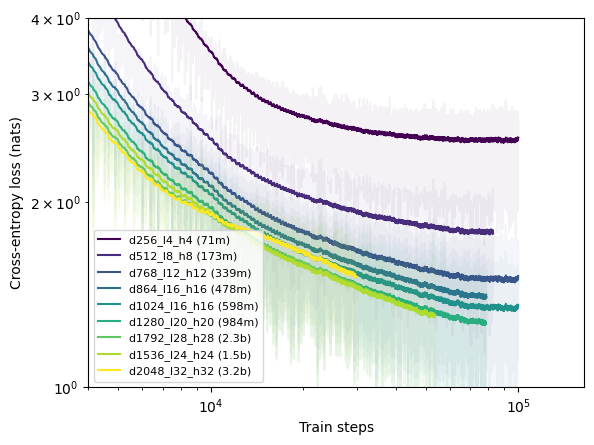

In [3]:
# plot the loss curves for the trainscratch01 runs
colors = plt.cm.viridis(np.linspace(0, 1, len(run_ids_scratch)))
for i, (run_name, run_id) in enumerate(run_ids_scratch.items()):
    try:
        history = data_scratch[run_name]["history"]
        plt.plot(history['train/global_step'], history['train/loss'], color=colors[i], alpha=0.05)
        ema_loss = history['train/loss'].ewm(alpha=0.01).mean().to_numpy()
        n_params = data_scratch[run_name]["n_params"]
        n_params_label = f"{n_params/1e6:.0f}m" if n_params < 1e9 else f"{n_params/1e9:.1f}b"
        plt.plot(history['train/global_step'], ema_loss, color=colors[i], label=f"{run_name.split('/')[-1]} ({n_params_label})")
    except Exception as e:
        print(f"Error loading run {run_name}: {e}")

plt.xscale('log')
plt.yscale('log')
plt.xlim(4e3, None)
plt.ylim(1.0, 4)
plt.legend(loc='lower left', prop={'size': 8})
plt.xlabel("Train steps")
plt.ylabel("Cross-entropy loss (nats)")

In [4]:
username = "ericjmichaud_"
project_name = "huggingface"
run_dir = "/n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00"

runs = api.runs(f"{username}/{project_name}")
run_ids_distill = {}
for run in runs:
    if run_dir in run.name:
        run_ids_distill[run.name] = run.id

data_distill = {}
for i, (run_name, run_id) in tqdm(enumerate(run_ids_distill.items())):
    try:
        run = api.run(f"{username}/{project_name}/{run_id}")
        config = run.config
        summary = run.summary
        history = pd.DataFrame(list(run.scan_history()))
        checkpoint = os.listdir(run_name)[-1]
        params = load_file(os.path.join(run_name, checkpoint, "model.safetensors"))
        n_params = sum(p.numel() for p in params.values())  
        data_distill[run_name] = {
            "config": config,
            "summary": summary,
            "history": history,
            "n_params": n_params
        }
    except Exception as e:
        print(f"Error loading run {run_name}: {e}")

1it [00:00,  1.42it/s]

Error loading run /n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d256_l4_h4: list index out of range


2it [00:01,  1.61it/s]

Error loading run /n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d512_l8_h8: list index out of range


9it [02:35, 17.33s/it]

Error loading run /n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d2048_l32_h32: No such file or directory: "/n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d2048_l32_h32/checkpoint-5000/model.safetensors"


Error loading run /n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d256_l4_h4: '/n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d256_l4_h4'
Error loading run /n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d512_l8_h8: '/n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d512_l8_h8'
Error loading run /n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d2048_l32_h32: '/n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d2048_l32_h32'


Text(0, 0.5, 'Cross-entropy loss (nats)')

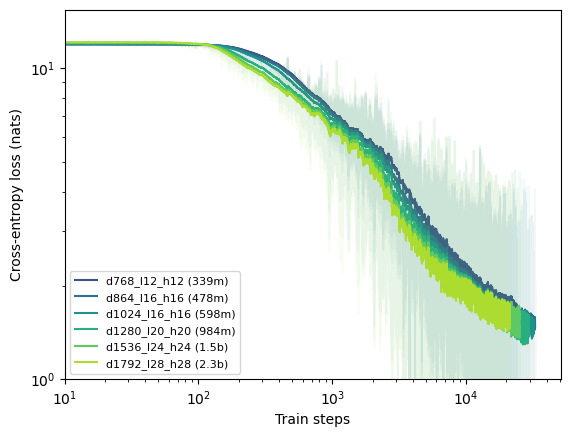

In [5]:
# plot the loss curves for the distillscratch00 runs
colors = plt.cm.viridis(np.linspace(0, 1, len(run_ids_distill)))
for i, (run_name, run_id) in enumerate(run_ids_distill.items()):
    try:
        history = data_distill[run_name]["history"]
        plt.plot(history['train/global_step'], history['train/student_ce_loss'], color=colors[i], alpha=0.05)
        ema_loss = history['train/student_ce_loss'].ewm(alpha=0.01).mean().to_numpy()
        n_params = data_distill[run_name]["n_params"]
        n_params_label = f"{n_params/1e6:.0f}m" if n_params < 1e9 else f"{n_params/1e9:.1f}b"
        plt.plot(history['train/global_step'], ema_loss, color=colors[i], label=f"{run_name.split('/')[-1]} ({n_params_label})")
    except Exception as e:
        print(f"Error loading run {run_name}: {e}")

plt.xscale('log')
plt.yscale('log')
plt.xlim(1e1, None)
plt.ylim(1.0, None)
plt.legend(loc='lower left', prop={'size': 8})
plt.xlabel("Train steps")
plt.ylabel("Cross-entropy loss (nats)")

In [6]:
username = "ericjmichaud_"
project_name = "huggingface"
run_dir = "/n/netscratch/iaifi_lab/Lab/ericjm/narrow/pruneandtrain01"

runs = api.runs(f"{username}/{project_name}")
run_ids_prune = {}
for run in runs:
    if run_dir in run.name:
        run_ids_prune[run.name] = run.id

data_prune = {}
for i, (run_name, run_id) in tqdm(enumerate(run_ids_prune.items())):
    try:
        run = api.run(f"{username}/{project_name}/{run_id}")
        config = run.config
        summary = run.summary
        history = pd.DataFrame(list(run.scan_history()))
        mask = torch.load(os.path.join(run_name, "pruning_mask.pt"), map_location=torch.device("cpu"))
        n_params = sum(m.sum().item() for m in mask.values())
        data_prune[run_name] = {
            "config": config,
            "summary": summary,
            "history": history,
            "n_params": n_params
        }
    except Exception as e:
        print(f"Error loading run {run_name}: {e}")

7it [01:06,  9.48s/it]


Text(0, 0.5, 'Cross-entropy loss (nats)')

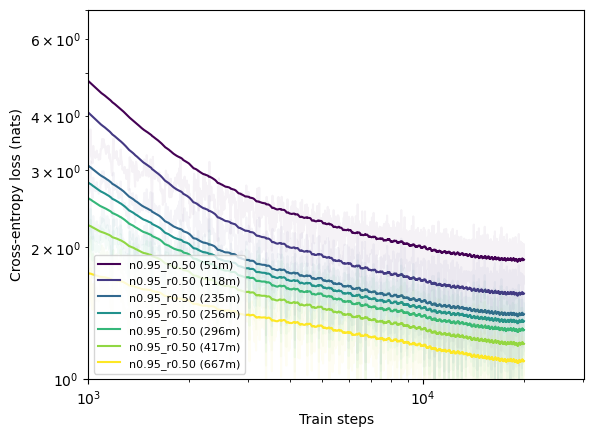

In [8]:
# plot the loss curves for the pruneandtrain01 runs
colors = plt.cm.viridis(np.linspace(0, 1, len(run_ids_prune)))
network_sizes = sorted([d['n_params'] for d in data_prune.values()])
data_for_plot = []
for i, (run_name, run_id) in enumerate(run_ids_prune.items()):
    try:
        history = data_prune[run_name]["history"]
        # plt.plot(history['train/global_step'], history['train/loss'], color=colors[i], alpha=0.05)
        ema_loss = history['train/loss'].ewm(alpha=0.01).mean().to_numpy()
        n_params = data_prune[run_name]["n_params"]
        n_params_label = f"{n_params/1e6:.0f}m" if n_params < 1e9 else f"{n_params/1e9:.1f}b"
        # plt.plot(history['train/global_step'], ema_loss, color=colors[network_sizes.index(n_params)], label=f"{run_name.split('/')[-1]} ({n_params_label})")
        data_for_plot.append((n_params, n_params_label, history['train/global_step'], history['train/loss'], ema_loss))
    except Exception as e:
        print(f"Error loading run {run_name}: {e}")

data_for_plot = sorted(data_for_plot, key=lambda x: x[0])
for n_params, n_params_label, x, y, ema_y in data_for_plot:
    plt.plot(x, y, color=colors[network_sizes.index(n_params)], alpha=0.05)
    plt.plot(x, ema_y, color=colors[network_sizes.index(n_params)], label=f"{run_name.split('/')[-1]} ({n_params_label})")

plt.xscale('log')
plt.yscale('log')
plt.xlim(1e3, None)
plt.ylim(1.0, 7)
plt.legend(loc='lower left', prop={'size': 8})
plt.xlabel("Train steps")
plt.ylabel("Cross-entropy loss (nats)")

Error loading run /n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d256_l4_h4: '/n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d256_l4_h4'
Error loading run /n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d512_l8_h8: '/n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d512_l8_h8'
Error loading run /n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d2048_l32_h32: '/n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d2048_l32_h32'


Text(0, 0.5, 'Cross-entropy loss (nats)')

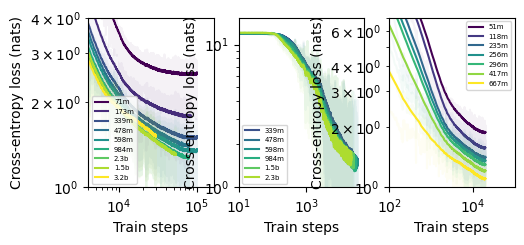

In [24]:
plt.figure(figsize=(5.5, 2.2))

plt.subplot(1, 3, 1)

# plot the loss curves for the trainscratch01 runs
colors = plt.cm.viridis(np.linspace(0, 1, len(run_ids_scratch)))
for i, (run_name, run_id) in enumerate(run_ids_scratch.items()):
    try:
        history = data_scratch[run_name]["history"]
        plt.plot(history['train/global_step'], history['train/loss'], color=colors[i], alpha=0.05)
        ema_loss = history['train/loss'].ewm(alpha=0.01).mean().to_numpy()
        n_params = data_scratch[run_name]["n_params"]
        n_params_label = f"{n_params/1e6:.0f}m" if n_params < 1e9 else f"{n_params/1e9:.1f}b"
        # plt.plot(history['train/global_step'], ema_loss, color=colors[i], label=f"{run_name.split('/')[-1]} ({n_params_label})")
        plt.plot(history['train/global_step'], ema_loss, color=colors[i], label=f"{n_params_label}")
    except Exception as e:
        print(f"Error loading run {run_name}: {e}")

plt.xscale('log')
plt.yscale('log')
plt.xlim(4e3, None)
plt.ylim(1.0, 4)
plt.legend(loc='lower left', prop={'size': 5})
plt.xlabel("Train steps")
plt.ylabel("Cross-entropy loss (nats)")



plt.subplot(1, 3, 2)

# plot the loss curves for the distillscratch00 runs
colors = plt.cm.viridis(np.linspace(0, 1, len(run_ids_distill)))
for i, (run_name, run_id) in enumerate(run_ids_distill.items()):
    try:
        history = data_distill[run_name]["history"]
        plt.plot(history['train/global_step'], history['train/student_ce_loss'], color=colors[i], alpha=0.05)
        ema_loss = history['train/student_ce_loss'].ewm(alpha=0.01).mean().to_numpy()
        n_params = data_distill[run_name]["n_params"]
        n_params_label = f"{n_params/1e6:.0f}m" if n_params < 1e9 else f"{n_params/1e9:.1f}b"
        # plt.plot(history['train/global_step'], ema_loss, color=colors[i], label=f"{run_name.split('/')[-1]} ({n_params_label})")
        plt.plot(history['train/global_step'], ema_loss, color=colors[i], label=f"{n_params_label}")
    except Exception as e:
        print(f"Error loading run {run_name}: {e}")

plt.xscale('log')
plt.yscale('log')
plt.xlim(1e1, None)
plt.ylim(1.0, None)
plt.legend(loc='lower left', prop={'size': 5})
plt.xlabel("Train steps")
plt.ylabel("Cross-entropy loss (nats)")


plt.subplot(1, 3, 3)

# plot the loss curves for the pruneandtrain01 runs
colors = plt.cm.viridis(np.linspace(0, 1, len(run_ids_prune)))
network_sizes = sorted([d['n_params'] for d in data_prune.values()])
data_for_plot = []
for i, (run_name, run_id) in enumerate(run_ids_prune.items()):
    try:
        history = data_prune[run_name]["history"]
        # plt.plot(history['train/global_step'], history['train/loss'], color=colors[i], alpha=0.05)
        ema_loss = history['train/loss'].ewm(alpha=0.01).mean().to_numpy()
        n_params = data_prune[run_name]["n_params"]
        n_params_label = f"{n_params/1e6:.0f}m" if n_params < 1e9 else f"{n_params/1e9:.1f}b"
        # plt.plot(history['train/global_step'], ema_loss, color=colors[network_sizes.index(n_params)], label=f"{run_name.split('/')[-1]} ({n_params_label})")
        data_for_plot.append((n_params, n_params_label, history['train/global_step'], history['train/loss'], ema_loss))
    except Exception as e:
        print(f"Error loading run {run_name}: {e}")

data_for_plot = sorted(data_for_plot, key=lambda x: x[0])
for n_params, n_params_label, x, y, ema_y in data_for_plot:
    plt.plot(x, y, color=colors[network_sizes.index(n_params)], alpha=0.05)
    # plt.plot(x, ema_y, color=colors[network_sizes.index(n_params)], label=f"{run_name.split('/')[-1]} ({n_params_label})")
    plt.plot(x, ema_y, color=colors[network_sizes.index(n_params)], label=f"{n_params_label}")

plt.xscale('log')
plt.yscale('log')
plt.ylim(1.0, 7)
plt.xlim(1e2, 1e5)
# plt.xticks([1e3, 1e4, 1e5])
plt.legend(loc='upper right', prop={'size': 5})
plt.xlabel("Train steps")
plt.ylabel("Cross-entropy loss (nats)")





In [31]:
def color_from_params(n_params):
    bottom = 5e7
    top = 3.2e9
    log_bottom = np.log10(bottom)
    log_top = np.log10(top)
    log_n_params = np.log10(n_params)
    value = (log_n_params - log_bottom) / (log_top - log_bottom)
    return plt.cm.viridis(value)


Error loading run /n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d256_l4_h4: '/n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d256_l4_h4'
Error loading run /n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d512_l8_h8: '/n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d512_l8_h8'
Error loading run /n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d2048_l32_h32: '/n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d2048_l32_h32'


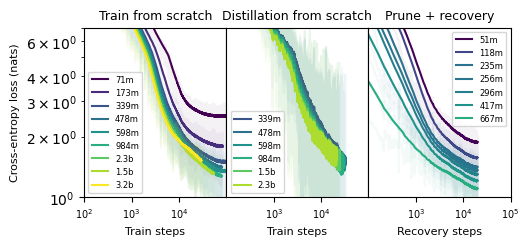

In [51]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(5.5, 2.2))

# First subplot: capture its axes for sharing
ax1 = plt.subplot(1, 3, 1)

# plot the loss curves for the trainscratch01 runs
colors = plt.cm.viridis(np.linspace(0, 1, len(run_ids_scratch)))
for i, (run_name, run_id) in enumerate(run_ids_scratch.items()):
    try:
        history = data_scratch[run_name]["history"]
        plt.plot(history['train/global_step'], history['train/loss'], color=colors[i], alpha=0.05)
        ema_loss = history['train/loss'].ewm(alpha=0.01).mean().to_numpy()
        n_params = data_scratch[run_name]["n_params"]
        n_params_label = f"{n_params/1e6:.0f}m" if n_params < 1e9 else f"{n_params/1e9:.1f}b"
        plt.plot(history['train/global_step'], ema_loss, color=colors[i], label=f"{n_params_label}")
    except Exception as e:
        print(f"Error loading run {run_name}: {e}")

plt.xscale('log')
plt.yscale('log')
plt.xlim(1e2, 1e5)
plt.ylim(1.0, 4)
plt.xticks([1e2, 1e3, 1e4], fontsize=7)
plt.legend(loc='lower left', prop={'size': 6})
plt.title("Train from scratch", fontsize=9)
plt.xlabel("Train steps", fontsize=8)
plt.ylabel("Cross-entropy loss (nats)", fontsize=8)


# Second subplot: share y-axis, then hide its y-axis
ax2 = plt.subplot(1, 3, 2, sharey=ax1)

# plot the loss curves for the distillscratch00 runs
colors = plt.cm.viridis(np.linspace(0, 1, len(run_ids_distill)))
for i, (run_name, run_id) in enumerate(run_ids_distill.items()):
    try:
        history = data_distill[run_name]["history"]
        plt.plot(history['train/global_step'], history['train/student_ce_loss'], color=colors[i], alpha=0.05)
        ema_loss = history['train/student_ce_loss'].ewm(alpha=0.01).mean().to_numpy()
        n_params = data_distill[run_name]["n_params"]
        n_params_label = f"{n_params/1e6:.0f}m" if n_params < 1e9 else f"{n_params/1e9:.1f}b"
        plt.plot(history['train/global_step'], ema_loss, color=colors[i], label=f"{n_params_label}")
    except Exception as e:
        print(f"Error loading run {run_name}: {e}")

plt.xscale('log')
plt.yscale('log')
plt.xlim(1e2, 1e5)
plt.ylim(1.0, None)
plt.xticks([1e3, 1e4], fontsize=7)
plt.legend(loc='lower left', prop={'size': 6})
plt.title("Distillation from scratch", fontsize=9)
plt.xlabel("Train steps", fontsize=8)

# hide ticks and labels on the y-axis
ax2.yaxis.set_visible(False)


# Third subplot: share y-axis, then hide its y-axis
ax3 = plt.subplot(1, 3, 3, sharey=ax1)

# plot the loss curves for the pruneandtrain01 runs
colors = plt.cm.viridis(np.linspace(0, 1, len(run_ids_prune)))
network_sizes = sorted([d['n_params'] for d in data_prune.values()])
data_for_plot = []
for i, (run_name, run_id) in enumerate(run_ids_prune.items()):
    try:
        history = data_prune[run_name]["history"]
        ema_loss = history['train/loss'].ewm(alpha=0.01).mean().to_numpy()
        n_params = data_prune[run_name]["n_params"]
        n_params_label = f"{n_params/1e6:.0f}m" if n_params < 1e9 else f"{n_params/1e9:.1f}b"
        data_for_plot.append((n_params, n_params_label, history['train/global_step'], history['train/loss'], ema_loss))
    except Exception as e:
        print(f"Error loading run {run_name}: {e}")

data_for_plot = sorted(data_for_plot, key=lambda x: x[0])
for n_params, n_params_label, x, y, ema_y in data_for_plot:
    plt.plot(x, y, color=color_from_params(n_params), alpha=0.05)
    plt.plot(x, ema_y, color=color_from_params(n_params), label=f"{n_params_label}")

plt.xscale('log')
plt.yscale('log')
plt.xlim(1e2, 1e5)
plt.ylim(1.0, 7)
plt.xticks([1e3, 1e4, 1e5], fontsize=7)
plt.legend(loc='upper right', prop={'size': 6})
plt.title("Prune + recovery", fontsize=9)
plt.xlabel("Recovery steps", fontsize=8)

# hide ticks and labels on the y-axis
ax3.yaxis.set_visible(False)

plt.subplots_adjust(wspace=0)

plt.savefig("figures/training-run-tripanel.png", dpi=250)

Error loading run /n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d256_l4_h4: '/n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d256_l4_h4'
Error loading run /n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d512_l8_h8: '/n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d512_l8_h8'
Error loading run /n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d2048_l32_h32: '/n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d2048_l32_h32'


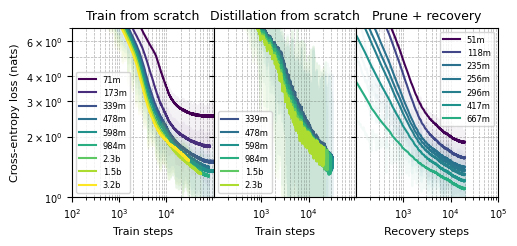

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# create 3 subplots sharing the y-axis
fig, (ax1, ax2, ax3) = plt.subplots(
    1, 3,
    figsize=(5.5, 2.2),
    sharey=True
)

# --- 1) Train from scratch ---
colors = plt.cm.viridis(np.linspace(0, 1, len(run_ids_scratch)))
for i, (run_name, run_id) in enumerate(run_ids_scratch.items()):
    try:
        history = data_scratch[run_name]["history"]
        ax1.plot(
            history['train/global_step'],
            history['train/loss'],
            color=colors[i],
            alpha=0.05
        )
        ema_loss = history['train/loss'].ewm(alpha=0.01).mean().to_numpy()
        n_params = data_scratch[run_name]["n_params"]
        n_params_label = (
            f"{n_params/1e6:.0f}m"
            if n_params < 1e9
            else f"{n_params/1e9:.1f}b"
        )
        ax1.plot(
            history['train/global_step'],
            ema_loss,
            color=colors[i],
            label=n_params_label
        )
    except Exception as e:
        print(f"Error loading run {run_name}: {e}")

ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1e2, 1e5)
ax1.set_ylim(1.0, 4)
ax1.set_xticks([1e2, 1e3, 1e4])
ax1.tick_params(axis='x', labelsize=7)

# custom y-ticks and labels on ax1
ax1.set_yticks([1, 2, 3, 4, 6])
ax1.set_yticklabels(["1", "2", "3", "4", "6"], fontsize=7)

ax1.legend(loc='lower left', prop={'size': 6})
ax1.set_title("Train from scratch", fontsize=9)
ax1.set_xlabel("Train steps", fontsize=8)
ax1.set_ylabel("Cross-entropy loss (nats)", fontsize=8)

# light grid
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)


# --- 2) Distillation from scratch ---
colors = plt.cm.viridis(np.linspace(0, 1, len(run_ids_distill)))
for i, (run_name, run_id) in enumerate(run_ids_distill.items()):
    try:
        history = data_distill[run_name]["history"]
        ax2.plot(
            history['train/global_step'],
            history['train/student_ce_loss'],
            color=colors[i],
            alpha=0.05
        )
        ema_loss = history['train/student_ce_loss'].ewm(alpha=0.01).mean().to_numpy()
        n_params = data_distill[run_name]["n_params"]
        n_params_label = (
            f"{n_params/1e6:.0f}m"
            if n_params < 1e9
            else f"{n_params/1e9:.1f}b"
        )
        ax2.plot(
            history['train/global_step'],
            ema_loss,
            color=colors[i],
            label=n_params_label
        )
    except Exception as e:
        print(f"Error loading run {run_name}: {e}")

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(1e2, 1e5)
ax2.set_ylim(1.0, None)
ax2.set_xticks([1e3, 1e4])
ax2.tick_params(axis='x', labelsize=7)

# hide only the y-axis labels but keep tick marks
ax2.set_yticks([1, 2, 3, 4, 6])
ax2.tick_params(axis='y', labelleft=False)

ax2.legend(loc='lower left', prop={'size': 6})
ax2.set_title("Distillation from scratch", fontsize=9)
ax2.set_xlabel("Train steps", fontsize=8)

ax2.grid(True, which='both', linestyle='--', linewidth=0.5)


# --- 3) Prune + recovery ---
colors = plt.cm.viridis(np.linspace(0, 1, len(run_ids_prune)))
data_for_plot = []
for i, (run_name, run_id) in enumerate(run_ids_prune.items()):
    try:
        history = data_prune[run_name]["history"]
        ema_loss = history['train/loss'].ewm(alpha=0.01).mean().to_numpy()
        n_params = data_prune[run_name]["n_params"]
        n_params_label = (
            f"{n_params/1e6:.0f}m"
            if n_params < 1e9
            else f"{n_params/1e9:.1f}b"
        )
        data_for_plot.append((
            n_params,
            n_params_label,
            history['train/global_step'],
            history['train/loss'],
            ema_loss
        ))
    except Exception as e:
        print(f"Error loading run {run_name}: {e}")

# sort by model size for consistent coloring/legend order
data_for_plot.sort(key=lambda x: x[0])
for n_params, n_params_label, x, y, ema_y in data_for_plot:
    c = color_from_params(n_params)
    ax3.plot(x, y, color=c, alpha=0.05)
    ax3.plot(x, ema_y, color=c, label=n_params_label)

ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.set_xlim(1e2, 1e5)
ax3.set_ylim(1.0, 7)
ax3.set_xticks([1e3, 1e4, 1e5])
ax3.tick_params(axis='x', labelsize=7)

# hide only the y-axis labels but keep tick marks
ax3.set_yticks([1, 2, 3, 4, 6])
ax3.tick_params(axis='y', labelleft=False)

ax3.legend(loc='upper right', prop={'size': 6})
ax3.set_title("Prune + recovery", fontsize=9)
ax3.set_xlabel("Recovery steps", fontsize=8)

ax3.grid(True, which='both', linestyle='--', linewidth=0.5)


# tighten up
fig.subplots_adjust(wspace=0)

# save
fig.savefig("figures/training-run-tripanel.png", dpi=250)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker

# Setup colormap and normalization
norm = mcolors.LogNorm(vmin=5e7, vmax=3.2e9)
cmap = plt.cm.viridis

# Create figure
plt.figure(figsize=(5.5, 2))
plt.subplots_adjust(wspace=0)

# Define subplot titles and data mappings
titles = ["Scratch Runs", "Distill Runs", "Prune Runs"]
data_sets = [data_scratch, data_distill, data_prune]
run_ids_sets = [run_ids_scratch, run_ids_distill, run_ids_prune]
y_fields = ['loss', 'student_ce_loss', 'loss']
xlabels = ["Train steps", "Train steps", "Recovery steps"]
x_ticks_sets = [([1e2, 1e3, 1e4], ['100', '1k', '10k']),
               ([1e3, 1e4], ['1k', '10k']),
               ([1e3, 1e4, 1e5], ['1k', '10k', '100k'])]

# Plot each subplot
for i, (title, data, run_ids, y_field, xlabel, (xticks, xtick_labels)) in enumerate(zip(
        titles, data_sets, run_ids_sets, y_fields, xlabels, x_ticks_sets), start=1):

    ax = plt.subplot(1, 3, i)

    for run_name in run_ids:
        try:
            history = data[run_name]["history"]
            n_params = data[run_name]["n_params"]
            color = cmap(norm(n_params))

            ax.plot(history['train/global_step'], history[f'train/{y_field}'], color=color, alpha=0.1)

            ema_loss = history[f'train/{y_field}'].ewm(alpha=0.01).mean().to_numpy()
            ax.plot(history['train/global_step'], ema_loss, color=color)
        except Exception as e:
            print(f"Error loading run {run_name}: {e}")

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(1e2, 1e5)
    ax.set_ylim(1.0, 9)

    ax.set_xticks(xticks, xtick_labels)

    if i == 1:
        ax.set_ylabel("Cross-entropy loss (nats)", fontsize=8)
        ax.yaxis.set_major_locator(ticker.FixedLocator([1, 2, 3, 4, 6, 8]))
        ax.yaxis.set_major_formatter(ticker.FixedFormatter(["1", "2", "3", "4", "6", "8"]))
    else:
        ax.yaxis.set_major_formatter(ticker.NullFormatter())  # hides major tick labels
        ax.yaxis.set_minor_formatter(ticker.NullFormatter())  # hides minor tick labels

    ax.set_xlabel(xlabel, fontsize=8)
    ax.set_title(title, fontsize=8)
    ax.tick_params(axis='x', labelsize=7)
    ax.tick_params(axis='y', labelsize=6)
    ax.grid(True, color='grey', linestyle='-', linewidth=0.5, alpha=0.5, which='both')

# Colorbar
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gcf().axes, location='right', pad=0.02)
cbar.set_label("# of Network Parameters", fontsize=8)
cbar.ax.tick_params(labelsize=7)

plt.savefig("figures/training-run-tripanel.png", dpi=250)


NameError: name 'data_scratch' is not defined

<Figure size 550x200 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker

# Create a LogNorm mapping for n_params in [5e7, 3.2e9] (50M to 3.2B).
norm = mcolors.LogNorm(vmin=5e7, vmax=3.2e9)
cmap = plt.cm.viridis

fig, axes = plt.subplots(1, 3, figsize=(5.5, 2), sharey=True)
plt.subplots_adjust(wspace=0)  # No horizontal space between subplots

############################
# Left plot: trainscratch01
############################
ax = axes[0]
for run_name, run_id in run_ids_scratch.items():
    try:
        history = data_scratch[run_name]["history"]
        n_params = data_scratch[run_name]["n_params"]
        
        # Map n_params to a viridis color based on our LogNorm
        color = cmap(norm(n_params))
        
        # Raw loss
        ax.plot(history['train/global_step'],
                history['train/loss'],
                color=color,
                alpha=0.1)
        
        # Smoothed / EMA loss
        ema_loss = history['train/loss'].ewm(alpha=0.01).mean().to_numpy()
        n_params_label = (f"{n_params/1e6:.0f}m" if n_params < 1e9 
                          else f"{n_params/1e9:.1f}b")
        ax.plot(history['train/global_step'],
                ema_loss,
                color=color,
                label=f"{run_name.split('/')[-1]} ({n_params_label})")
    except Exception as e:
        print(f"Error loading run {run_name}: {e}")

# Log scales and tick formatting
ax.set_xscale('log')
ax.set_yscale('log') # Set scale *before* setting specific ticks

ax.set_xlim(1e2, 1e5)
ax.set_ylim(1.0, 9) # Make sure ylim includes your desired ticks

# Custom X ticks (your original code is fine)
ax.set_xticks([1e2, 1e3, 1e4], ['100', '1k', '10k'])

# --- SOLUTION: Use FixedLocator and FixedFormatter for Y-axis ---
y_tick_values = [1, 2, 4, 8]
y_tick_labels = ["1", "2", "4", "8"] # Use strings for labels
ax.yaxis.set_major_locator(ticker.FixedLocator(y_tick_values))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(y_tick_labels))

# Optional: Remove minor ticks on the y-axis if they appear automatically
ax.yaxis.set_minor_locator(ticker.NullLocator())
# --- End of Solution ---

ax.set_xlabel("Train steps", fontsize=8)
ax.set_ylabel("Cross-entropy loss (nats)", fontsize=8)
ax.tick_params(axis='x', labelsize=7)
ax.tick_params(axis='y', labelsize=6)
ax.set_title("Scratch Runs", fontsize=8)
ax.grid(True, color='grey', linestyle='-', linewidth=0.5, alpha=0.5, which='both')


###############################
# Middle plot: distillscratch00
###############################
ax = axes[1]
for run_name, run_id in run_ids_distill.items():
    try:
        history = data_distill[run_name]["history"]
        n_params = data_distill[run_name]["n_params"]
        color = cmap(norm(n_params))
        
        ax.plot(history['train/global_step'],
                history['train/student_ce_loss'],
                color=color,
                alpha=0.1)
        
        ema_loss = history['train/student_ce_loss'].ewm(alpha=0.01).mean().to_numpy()
        n_params_label = (f"{n_params/1e6:.0f}m" if n_params < 1e9 
                          else f"{n_params/1e9:.1f}b")
        ax.plot(history['train/global_step'],
                ema_loss,
                color=color,
                label=f"{run_name.split('/')[-1]} ({n_params_label})")
    except Exception as e:
        print(f"Error loading run {run_name}: {e}")

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e2, 1e5)
ax.set_ylim(1.0, 9)
ax.set_xticks([1e3, 1e4], ['1k', '10k'])
ax.set_xlabel("Train steps", fontsize=8)
ax.tick_params(axis='x', labelsize=7)
ax.tick_params(axis='y', labelleft=False)  # No y-axis labels in middle
ax.set_title("Distill Runs", fontsize=8)
ax.grid(True, color='grey', linestyle='-', linewidth=0.5, alpha=0.5, which='both')


###############################
# Right plot: pruneandtrain01
###############################
ax = axes[2]
network_sizes = sorted([d['n_params'] for d in data_prune.values()])
for run_name, run_id in run_ids_prune.items():
    try:
        history = data_prune[run_name]["history"]
        n_params = data_prune[run_name]["n_params"]
        
        # Map n_params to color
        color = cmap(norm(n_params))
        
        ax.plot(history['train/global_step'],
                history['train/loss'],
                color=color,
                alpha=0.1)
        
        ema_loss = history['train/loss'].ewm(alpha=0.01).mean().to_numpy()
        n_params_label = (f"{n_params/1e6:.0f}m" if n_params < 1e9 
                          else f"{n_params/1e9:.1f}b")
        # Use a consistent color for the smoothed line
        ax.plot(history['train/global_step'],
                ema_loss,
                color=color,
                label=f"{run_name.split('/')[-1]} ({n_params_label})")
    except Exception as e:
        print(f"Error loading run {run_name}: {e}")

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e2, 1e5)
ax.set_ylim(1.0, 9)
ax.set_xticks([1e3, 1e4, 1e5], ['1k', '10k', '100k'])
ax.set_xlabel("Recovery steps", fontsize=8)
ax.tick_params(axis='x', labelsize=7)
ax.tick_params(axis='y', labelleft=False)  # Remove y tick labels on right plot
ax.set_title("Prune Runs", fontsize=8)
ax.grid(True, color='grey', linestyle='-', linewidth=0.5, alpha=0.5, which='both')

###############################
# Add colorbar on the right
###############################
# Create a "blank" mappable object with our normalization & colormap
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Required for older matplotlib versions

# Add a vertical colorbar using all three axes so it's on the right side
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), location='right', pad=0.02)
cbar.set_label("Number of parameters", fontsize=8)
cbar.ax.tick_params(labelsize=7)  # Make colorbar tick labels smaller

# plt.subplots_adjust(left=0.2, right=0.75, bottom=0.2, top=0.9)

plt.savefig("figures/training-run-tripanel.png", dpi=250)


Error loading run /n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d256_l4_h4: '/n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d256_l4_h4'
Error loading run /n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d512_l8_h8: '/n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d512_l8_h8'
Error loading run /n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d2048_l32_h32: '/n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d2048_l32_h32'


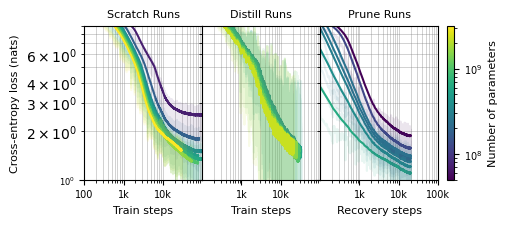

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker

# Create a LogNorm mapping for n_params in [5e7, 3.2e9] (50M to 3.2B).
norm = mcolors.LogNorm(vmin=5e7, vmax=3.2e9)
cmap = plt.cm.viridis

fig, axes = plt.subplots(1, 3, figsize=(5.5, 2), sharey=True)
plt.subplots_adjust(wspace=0)  # No horizontal space between subplots

############################
# Left plot: trainscratch01
############################
ax = axes[0]
for run_name, run_id in run_ids_scratch.items():
    try:
        history = data_scratch[run_name]["history"]
        n_params = data_scratch[run_name]["n_params"]
        
        # Map n_params to a viridis color based on our LogNorm
        color = cmap(norm(n_params))
        
        # Raw loss
        ax.plot(history['train/global_step'],
                history['train/loss'],
                color=color,
                alpha=0.1)
        
        # Smoothed / EMA loss
        ema_loss = history['train/loss'].ewm(alpha=0.01).mean().to_numpy()
        n_params_label = (f"{n_params/1e6:.0f}m" if n_params < 1e9 
                          else f"{n_params/1e9:.1f}b")
        ax.plot(history['train/global_step'],
                ema_loss,
                color=color,
                label=f"{run_name.split('/')[-1]} ({n_params_label})")
    except Exception as e:
        print(f"Error loading run {run_name}: {e}")

# Log scales and tick formatting
ax.set_xscale('log')
ax.set_yscale('log') # Set scale *before* setting specific ticks

ax.set_xlim(1e2, 1e5)
ax.set_ylim(1.0, 9) # Make sure ylim includes your desired ticks

# Custom X ticks (your original code is fine)
ax.set_xticks([1e2, 1e3, 1e4], ['100', '1k', '10k'])

# --- SOLUTION: Use FixedLocator and FixedFormatter for Y-axis ---
y_tick_values = [1, 2, 4, 8]
y_tick_labels = ["1", "2", "4", "8"] # Use strings for labels
ax.yaxis.set_major_locator(ticker.FixedLocator(y_tick_values))
ax.yaxis.set_major_formatter(ticker.FixedFormatter(y_tick_labels))

# Optional: Remove minor ticks on the y-axis if they appear automatically
ax.yaxis.set_minor_locator(ticker.NullLocator())
# --- End of Solution ---

ax.set_xlabel("Train steps", fontsize=8)
ax.set_ylabel("Cross-entropy loss (nats)", fontsize=8)
ax.tick_params(axis='x', labelsize=7)
ax.tick_params(axis='y', labelsize=6)
ax.set_title("Scratch Runs", fontsize=8)
ax.grid(True, color='grey', linestyle='-', linewidth=0.5, alpha=0.5, which='both')


###############################
# Middle plot: distillscratch00
###############################
ax = axes[1]
for run_name, run_id in run_ids_distill.items():
    try:
        history = data_distill[run_name]["history"]
        n_params = data_distill[run_name]["n_params"]
        color = cmap(norm(n_params))
        
        ax.plot(history['train/global_step'],
                history['train/student_ce_loss'],
                color=color,
                alpha=0.1)
        
        ema_loss = history['train/student_ce_loss'].ewm(alpha=0.01).mean().to_numpy()
        n_params_label = (f"{n_params/1e6:.0f}m" if n_params < 1e9 
                          else f"{n_params/1e9:.1f}b")
        ax.plot(history['train/global_step'],
                ema_loss,
                color=color,
                label=f"{run_name.split('/')[-1]} ({n_params_label})")
    except Exception as e:
        print(f"Error loading run {run_name}: {e}")

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e2, 1e5)
ax.set_ylim(1.0, 9)
ax.set_xticks([1e3, 1e4], ['1k', '10k'])
ax.set_xlabel("Train steps", fontsize=8)
ax.tick_params(axis='x', labelsize=7)
ax.tick_params(axis='y', labelleft=False)  # No y-axis labels in middle
ax.set_title("Distill Runs", fontsize=8)
ax.grid(True, color='grey', linestyle='-', linewidth=0.5, alpha=0.5, which='both')


###############################
# Right plot: pruneandtrain01
###############################
ax = axes[2]
network_sizes = sorted([d['n_params'] for d in data_prune.values()])
for run_name, run_id in run_ids_prune.items():
    try:
        history = data_prune[run_name]["history"]
        n_params = data_prune[run_name]["n_params"]
        
        # Map n_params to color
        color = cmap(norm(n_params))
        
        ax.plot(history['train/global_step'],
                history['train/loss'],
                color=color,
                alpha=0.1)
        
        ema_loss = history['train/loss'].ewm(alpha=0.01).mean().to_numpy()
        n_params_label = (f"{n_params/1e6:.0f}m" if n_params < 1e9 
                          else f"{n_params/1e9:.1f}b")
        # Use a consistent color for the smoothed line
        ax.plot(history['train/global_step'],
                ema_loss,
                color=color,
                label=f"{run_name.split('/')[-1]} ({n_params_label})")
    except Exception as e:
        print(f"Error loading run {run_name}: {e}")

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e2, 1e5)
ax.set_ylim(1.0, 9)
ax.set_xticks([1e3, 1e4, 1e5], ['1k', '10k', '100k'])
ax.set_xlabel("Recovery steps", fontsize=8)
ax.tick_params(axis='x', labelsize=7)
ax.tick_params(axis='y', labelleft=False)  # Remove y tick labels on right plot
ax.set_title("Prune Runs", fontsize=8)
ax.grid(True, color='grey', linestyle='-', linewidth=0.5, alpha=0.5, which='both')

###############################
# Add colorbar on the right
###############################
# Create a "blank" mappable object with our normalization & colormap
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Required for older matplotlib versions

# Add a vertical colorbar using all three axes so it's on the right side
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), location='right', pad=0.02)
cbar.set_label("Number of parameters", fontsize=8)
cbar.ax.tick_params(labelsize=7)  # Make colorbar tick labels smaller

# plt.subplots_adjust(left=0.2, right=0.75, bottom=0.2, top=0.9)

plt.savefig("figures/training-run-tripanel.png", dpi=250)

Error loading run /n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d256_l4_h4: '/n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d256_l4_h4'
Error loading run /n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d512_l8_h8: '/n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d512_l8_h8'
Error loading run /n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d2048_l32_h32: '/n/netscratch/iaifi_lab/Lab/ericjm/narrow/distillscratch00/d2048_l32_h32'
[(np.int64(76021760), 666773063.0), (np.int64(143523840), 416580608.0), (np.int64(204800000), 295786496.0), (np.int64(254607360), 255521792.0), (np.int64(595722240), 118430140.0), (np.int64(304742400), 235387904.0)]


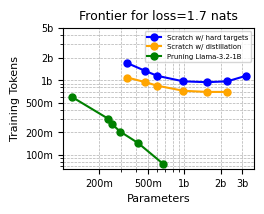

In [44]:
plt.figure(figsize=(2.5, 2))

target_loss = 1.7

# LLMS FROM SCRATCH w/ hard targets
BATCH_SIZE = 64
CONTEXT_LENGTH = 1024
TOKENS_PER_STEP = BATCH_SIZE * CONTEXT_LENGTH

points = []
for run_name, run_id in run_ids_scratch.items():
    try:
        history = data_scratch[run_name]["history"]
        n_params = data_scratch[run_name]["n_params"]
        steps = history['train/global_step']
        tokens = steps * TOKENS_PER_STEP
        loss_ema = history['train/loss'].ewm(alpha=0.01).mean().to_numpy()
        # get the index of the first time loss_ema is less than TARGET_LOSS
        if (loss_ema < target_loss).any():
            idx = np.where(loss_ema < target_loss)[0][0]
            points.append((tokens[idx], n_params))
    except Exception as e:
        print(f"Error loading run {run_name}: {e}")
if points:
    # sort points
    points = sorted(points, key=lambda x: x[1])
    tokens_frontier, n_params_frontier = zip(*points)
    plt.plot(n_params_frontier, tokens_frontier, 'o-', markersize=5, color="blue", label="Scratch w/ hard targets")


# LLMS FROM SCRATCH w/ DISTILLATION
BATCH_SIZE = 64
CONTEXT_LENGTH = 1024
TOKENS_PER_STEP = BATCH_SIZE * CONTEXT_LENGTH

points = []
for run_name, run_id in run_ids_distill.items():
    try:
        history = data_distill[run_name]["history"]
        n_params = data_distill[run_name]["n_params"]
        steps = history['train/global_step']
        tokens = steps * TOKENS_PER_STEP
        loss_ema = history['train/student_ce_loss'].ewm(alpha=0.01).mean().to_numpy()
        # get the index of the first time loss_ema is less than TARGET_LOSS
        if (loss_ema < target_loss).any():
            idx = np.where(loss_ema < target_loss)[0][0]
            points.append((tokens[idx], n_params))
    except Exception as e:
        print(f"Error loading run {run_name}: {e}")
if points:
    # sort points
    points = sorted(points, key=lambda x: x[1])
    tokens_frontier, n_params_frontier = zip(*points)
    plt.plot(n_params_frontier, tokens_frontier, 'o-', markersize=5, color="orange", label="Scratch w/ distillation")


# LLMS PRUNING AND TRAINING
BATCH_SIZE = 64
CONTEXT_LENGTH = 1024
TOKENS_PER_STEP = BATCH_SIZE * CONTEXT_LENGTH

points = []
for run_name, run_id in run_ids_prune.items():
    try:
        history = data_prune[run_name]["history"]
        n_params = data_prune[run_name]["n_params"]
        steps = history['train/global_step']
        tokens = steps * TOKENS_PER_STEP
        loss_ema = history['train/loss'].ewm(alpha=0.01).mean().to_numpy()
        # get the index of the first time loss_ema is less than TARGET_LOSS
        if (loss_ema < target_loss).any():
            idx = np.where(loss_ema < target_loss)[0][0]
            points.append((tokens[idx], n_params))
    except Exception as e:
        print(f"Error loading run {run_name}: {e}")
if points:
    print(points)
    # sort points
    points = sorted(points, key=lambda x: x[1])
    tokens_frontier, n_params_frontier = zip(*points)
    plt.plot(n_params_frontier, tokens_frontier, 'o-', markersize=5, color="green", label="Pruning Llama-3.2-1B")

plt.title(f"Frontier for loss={target_loss} nats", fontsize=9)
plt.xlabel('Parameters', fontsize=8)
plt.ylabel('Training Tokens', fontsize=8)
plt.xscale('log')
plt.yscale('log')
# plt.ylim(7e8, None)
# plt.xlim(4e8, None)
plt.grid(which='both', linestyle='--', linewidth=0.5)
# add x-tick labels like 200m, 500m, 800m, 1b, 2b, 3b
plt.xticks([2e8, 5e8, 1e9, 2e9, 3e9], ['200m', '500m', '1b', '2b', '3b'], fontsize=7)
# add y-tick labels 100m, 200m, 500m, 1b, 2b, 5b
plt.yticks([1e8, 2e8, 5e8, 1e9, 2e9, 5e9], ['100m', '200m', '500m', '1b', '2b', '5b'], fontsize=7)
plt.legend(prop={'size': 5})
plt.tight_layout(pad=0.2)
plt.savefig("figures/llmfrontierslosssmall.pdf")

In [1]:
data_prune

NameError: name 'data_prune' is not defined